In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import config
from src.util import video2images, get_video_folder_paths, seleccionar_imagen, merge_datasets
from src.model import autolabel_images, predict_and_visualice
from src.dataset_processing import run_processing_dataset
import os
import json
import supervision as sv
import cv2
from src.data_augmentation import augment_dataset

trying to load grounding dino directly


/home/minigo/anaconda3/envs/autolabel_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [56]:
# convertir los video en imagenes
# crear en el directorio raiz la ruta test\video_test\<sku del producto>
# colocar dentro un video y un archivo ontology.json con la ontología. 
video_path= get_video_folder_paths(config.VIDEO_TEST)[0]
print(video_path)

d:\Alexander\Go2Future\Autolabel_roboflow\test\video_test\7790040133488


In [57]:
# create image folder for each video folder
    
image_dir_path = os.path.join(config.IMAGE_TEST, os.path.basename(video_path))
if not os.path.exists(image_dir_path):
    os.mkdir(image_dir_path)

video2images(video_path, image_dir_path, frame_rate=200)

100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


In [146]:
# create dataset folder for each video folder
if not os.path.exists(config.DATA_TEST):
    os.mkdir(config.DATA_TEST)
    
dataset_dir_path = os.path.join(config.DATA_TEST, os.path.basename(video_path))
if not os.path.exists(dataset_dir_path):
    os.mkdir(dataset_dir_path)


In [147]:

autolabel_images(
            input_folder=image_dir_path,
            ontology=json.load(open(os.path.join(video_path, "ontology.json"))),
            box_threshold=0.35,
            text_threshold=0.25,
            output_folder=dataset_dir_path,
            extension=".jpg",
        )

Labeling d:\Alexander\Go2Future\Autolabel_roboflow\test\image_test\7790040133488\7790040133488_vertical_3-00005.jpg: 100%|██████████| 6/6 [02:32<00:00, 25.43s/it]


Labeled dataset created - ready for distillation.


In [151]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(dataset_dir_path, "train","labels")
IMAGES_DIRECTORY_PATH = os.path.join(dataset_dir_path, "train", "images")
DATA_YAML_PATH = os.path.join(dataset_dir_path, "data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

4

In [45]:
# create fuction to read a list of labels files .txt into a folder and erase empty files
# and remove images respect to the labels files

import os
def erase_empty_files(label_path, image_path):
    for lab_filename, image_filaname in zip(os.listdir(label_path), os.listdir(image_path)):
        if os.stat(os.path.join(label_path, lab_filename)).st_size == 0:
            os.remove(os.path.join(label_path, lab_filename))
            os.remove(os.path.join(image_path, image_filaname)
        )  
erase_empty_files(ANNOTATIONS_DIRECTORY_PATH ,IMAGES_DIRECTORY_PATH)    

In [150]:
run_processing_dataset(IMAGES_DIRECTORY_PATH, ANNOTATIONS_DIRECTORY_PATH, max_size=0.5, iou_threshold=0.1)


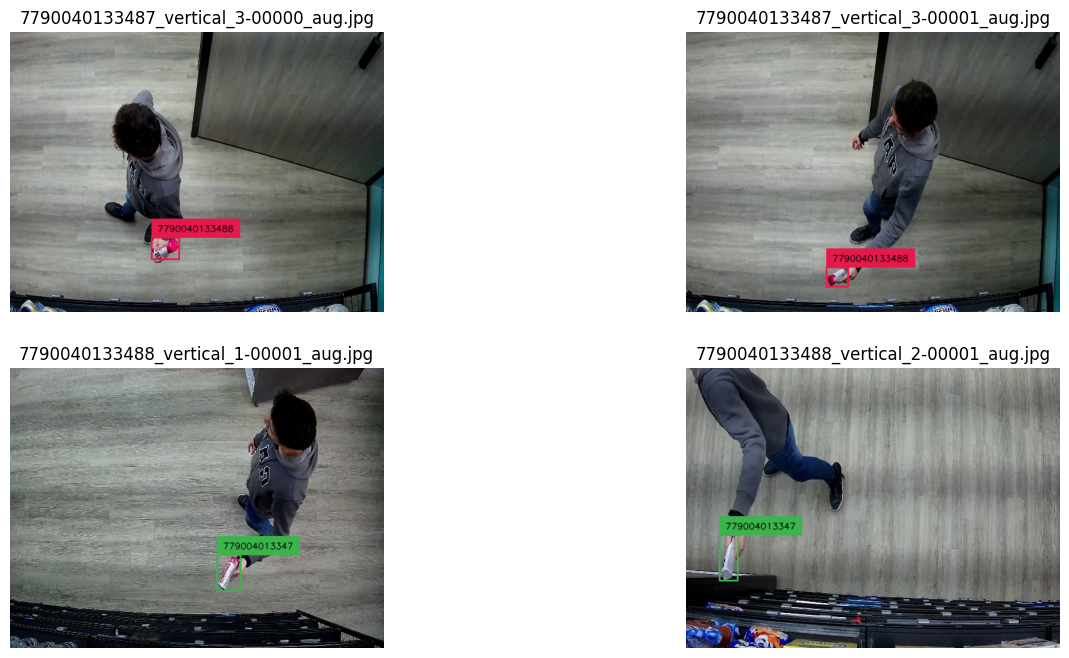

In [11]:
# Mostrar las anotaciones realizadas por el modelo base
SAMPLE_SIZE = 4
SAMPLE_GRID_SIZE = (2, 2)
SAMPLE_PLOT_SIZE = (16, 8)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

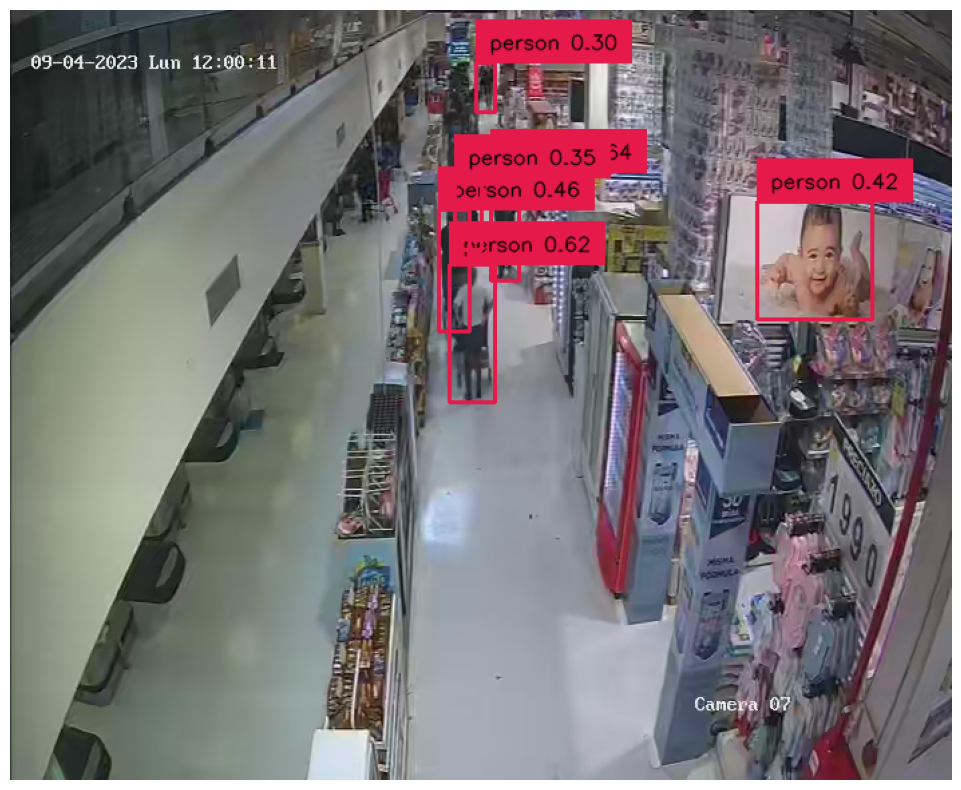

In [41]:
#image_path=os.path.join(config.IMAGE_DIR_PATH, "7790040133487/7790040133487_vertical_1-00000.jpg")
image_path=seleccionar_imagen()
predict_and_visualice(image_path, {"People": "person"}, 
    box_threshold=0.30,
    text_threshold=0.25,)

### Hcer merge de cada dataset individual

In [28]:
# Unir datasets
    # crear el path a la carpeta de merged dataset dentro de dataset
output_path = ("/media/minigo/DATA3/10k/autolabeling_dino/dataset/Merged_Dataset")
    # obtener el nombre de cada dataset individual dentro de dataset
dataset_="/media/minigo/DATA3/10k/autolabeling_dino/dataset"
folders = os.listdir("/media/minigo/DATA3/10k/autolabeling_dino/dataset")
    # Lista de paths de cada dataset individual
dataset_paths = [os.path.join(dataset_, folder) for folder in folders]
    # Hacer el merge
merge_datasets(dataset_paths, output_path)

INFO:root:Merging datasets...
100%|██████████| 80/80 [21:08<00:00, 15.86s/it]
INFO:root:Merged datasets created at /media/minigo/DATA3/10k/autolabeling_dino/dataset/Merged_Dataset


['7790240042108', '7792799000011', '7509552843071', '7509552843071', '7509552843071', '7509552843071', '7509552843101', '7509552843101', '7509552843101', '7509552843101', '7613031154111', '7613031154111', '7613031154111', '7613031154111', '7790040136069', '7790040136069', '7790040136069', '7790040136069', '7790070320858', '7790070320858', '7790070320858', '7790070320858', '7790132009158', '7790132009158', '7790132009158', '7790132009158', '7790139000424', '7790139000424', '7790139000424', '7790139000424', '7790240042108', '7790240042108', '7790240042108', '7790250026044', '7790250026044', '7790250026044', '7790250026044', '7790580134327', '7790580134327', '7790580134327', '7790580134327', '7790670051060', '7790670051060', '7790670051060', '7790670051060', '7790895067587', '7790895067587', '7790895067587', '7790895067587', '7791293045146', '7791293045146', '7791293045146', '7791293045146', '7791813421917', '7791813421917', '7791813421917', '7791813421917', '7792360071518', '779236007151

In [25]:
# Unir datasets
    # crear el path a la carpeta de merged dataset dentro de dataset
output_path = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset")
    # obtener el nombre de cada dataset individual dentro de dataset
folders = os.listdir(config.DATASET_DIR_PATH)
    # Lista de paths de cada dataset individual
dataset_paths = [os.path.join(config.DATASET_DIR_PATH, folder) for folder in folders]
    # Hacer el merge
merge_datasets(dataset_paths, output_path)

INFO:root:Merging datasets...
100%|██████████| 20/20 [00:00<00:00, 115.61it/s]
INFO:root:Merged datasets created at /home/minigo/Desktop/Revisar/Alexander_Resultados_Grounding DINO/Autolabeling_groundingDINO/autolabeling/dataset/Merged_Dataset


['7792900990699', '7790070320858', '7792360071518', '7790895067587', '7794000003712', '7790040136069', '7790250026044', '7613031154111', '7790240042108', '7790670051060', '7791293045146', '7790139000424', '7793147009137', '7790580134327', '7791813421917', '7509552843071', '7509552843101', '7792799000011', '7793253001186', '7790132009158']
['7792900990699', '7790070320858', '7792360071518', '7790895067587', '7794000003712', '7790040136069', '7790250026044', '7613031154111', '7790240042108', '7790670051060', '7791293045146', '7790139000424', '7793147009137', '7790580134327', '7791813421917', '7509552843071', '7509552843101', '7792799000011', '7793253001186', '7790132009158']


['7509552843101', '7793253001186']
['7509552843101', '7793253001186']


### Corregir errores de etiquetado

In [29]:
# Procesar Merged_Dataset/train para eliminar errores de anotación
run_processing_dataset(
        os.path.join(output_path, "train", "images"),
        os.path.join(output_path, "train", "labels"),
    )
    # Procesar Merged_Dataset/valid para eliminar errores de anotación
run_processing_dataset(
        os.path.join(output_path, "valid", "images"),
        os.path.join(output_path, "valid", "labels"),
    )

removed large
removed overlaping
removed empty
removed large
removed overlaping
removed empty


## Llevar todas las anotaciones a un video

In [19]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Augmented_Dataset/train/labels")
IMAGES_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Augmented_Dataset/train/images")
DATA_YAML_PATH = os.path.join(config.DATASET_DIR_PATH, "Augmented_Dataset/data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

32

## Data augmentation

In [4]:
dataset_path=os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset")
augmented_dataset_path=os.path.join(config.DATASET_DIR_PATH, "Augmented_Dataset")
# creating aumented datased directory
if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

augment_dataset(dataset_path, augmented_dataset_path, augmented_for=7)

INFO:root:Transforming data.yaml ...
INFO:root:Generating train augmented images ...
  1%|          | 16/1539 [00:01<02:26, 10.41it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  8%|▊         | 118/1539 [00:11<02:05, 11.33it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 10%|▉         | 151/1539 [00:15<02:06, 10.98it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 13%|█▎        | 204/1539 [00:20<02:07, 10.50it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 17%|█▋        | 259/1539 [00:26<01:57, 10.93it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 19%|█▉        | 291/1539 [00:29<02:01, 10.28it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 28%|██▊       | 436/1539 [00:44<01:38, 11.23it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 29%|██▉       | 448/1539 [00:46<01:53,  9.63it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 32%|███▏      | 493/1539 [00:50<01:33, 11.21it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 34%|███▍      | 526/1539 [00:54<01:32, 11.00it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 35%|███▌      | 539/1539 [00:55<01:31, 10.99it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 40%|███▉      | 613/1539 [01:03<01:29, 10.39it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 40%|███▉      | 615/1539 [01:03<01:24, 10.98it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 41%|████      | 627/1539 [01:04<01:20, 11.30it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 42%|████▏     | 645/1539 [01:06<01:21, 10.95it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 47%|████▋     | 721/1539 [01:13<01:17, 10.52it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 50%|████▉     | 762/1539 [01:18<01:11, 10.80it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 51%|█████     | 778/1539 [01:19<01:09, 10.93it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 52%|█████▏    | 796/1539 [01:21<01:05, 11.31it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 52%|█████▏    | 807/1539 [01:22<01:04, 11.37it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 63%|██████▎   | 972/1539 [01:39<00:55, 10.31it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 64%|██████▍   | 989/1539 [01:41<00:51, 10.69it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 73%|███████▎  | 1128/1539 [01:55<00:37, 10.84it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 75%|███████▍  | 1151/1539 [01:58<00:34, 11.22it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 75%|███████▌  | 1157/1539 [01:58<00:34, 11.16it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 77%|███████▋  | 1186/1539 [02:01<00:31, 11.31it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 78%|███████▊  | 1194/1539 [02:02<00:30, 11.33it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 78%|███████▊  | 1200/1539 [02:03<00:29, 11.54it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 80%|███████▉  | 1229/1539 [02:05<00:26, 11.70it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 82%|████████▏ | 1261/1539 [02:08<00:24, 11.57it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 85%|████████▌ | 1311/1539 [02:13<00:20, 11.29it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 88%|████████▊ | 1350/1539 [02:17<00:16, 11.59it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 90%|█████████ | 1391/1539 [02:21<00:13, 10.77it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 98%|█████████▊| 1502/1539 [02:33<00:03, 11.17it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 99%|█████████▉| 1527/1539 [02:35<00:01, 10.57it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


100%|██████████| 1539/1539 [02:37<00:00,  9.79it/s]
INFO:root:Data train augmentation ended ...
INFO:root:Addjusting validation data  ...
 13%|█▎        | 49/386 [00:00<00:03, 93.13it/s]

label file is empty
label file is empty


 49%|████▊     | 188/386 [00:02<00:02, 92.97it/s]

label file is empty


 54%|█████▍    | 208/386 [00:02<00:01, 92.52it/s]

label file is empty


 67%|██████▋   | 259/386 [00:02<00:01, 95.07it/s]

label file is empty
label file is empty
label file is empty


100%|██████████| 386/386 [00:04<00:00, 91.09it/s]
INFO:root:Data augmentation ended ...


In [3]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/valid/labels")
IMAGES_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/valid/images")
DATA_YAML_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

383

In [4]:
image_names = list(dataset.images.keys())

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

In [14]:
# Especificar la ruta del video de salida y la velocidad de fotogramas
video_name =os.path.join(config.DATASET_DIR_PATH, "anotaciones.mp4") 
fps = 2

# Obtener la altura y el ancho de la primera imagen
height, width, layers = images[0].shape

# Crear el objeto VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))

# Agregar cada imagen al video
for image in images:
    video.write(image)

# Liberar el objeto VideoWriter y cerrar la ventana
cv2.destroyAllWindows()
video.release()

## Salvar imagenes anotadas para visualización

In [5]:
# Crear una carpeta para almacenar las imágenes si no existe
anotate_images=os.path.join(config.DATASET_DIR_PATH, "imagenes_anotadas")
if not os.path.exists(anotate_images):
    os.makedirs(anotate_images)


# Guardar cada imagen como un archivo individual
for idx, image in enumerate(images):
    output_path = os.path.join(anotate_images, f"imagen_{idx+1}.png")
    cv2.imwrite(output_path, image)

print("Imágenes guardadas exitosamente.")

Imágenes guardadas exitosamente.
